[leiden algo documentation](https://leidenalg.readthedocs.io/en/latest/install.html)

# General Approach

In this analysis, we explore the clustering of scientific publications using the Leiden algorithm, with a focus on adjusting the algorithm's parameters to improve the coherence and relevance of the clusters formed. The Leiden algorithm, which improves upon the limitations of modularity optimization seen in previous methods, is employed for its effectiveness in identifying communities within networks. We particularly experiment with various resolution parameters, iterating through a range of values to tune the granularity of the clustering results. The objective is to find an optimal balance where clusters are neither too broad, encompassing multiple unrelated topics, nor too narrow, breaking down coherent subjects into excessive subgroups.

The analysis starts with the application of the Leiden algorithm using default settings and then progresses to more sophisticated implementations, including adjusting the resolution parameter to influence the size and coherence of clusters. This parameter tuning is crucial for addressing the resolution limit problem inherent in modularity-based community detection methods. By carefully selecting resolution parameters, we aim to achieve a set of clusters that are meaningful and manageable for qualitative analysis.

This process is supported by the creation of summary sheets and detailed exploratory sheets for each parameter set, facilitating a thorough review of the clustering outcomes. Parameters leading to the most coherent and distinct clusters, based on predefined decision criteria, are identified and selected for further analysis. The final selection of parameters is based on qualitative assessments of cluster coherence, ensuring that the clusters formed are both scientifically relevant and insightful for further research explorations.

Notes about the leiden algorithm:

### The most simpe implementation is this:

Here we would just use all default parameters.
The metrices are good, the qualitative assessment poor.
The `ModularityVertexPartition` is the default partitioning algorithm

- it is based on the modularity measure (link density within communities vs. link density between communities)
- Higher scires = stronger division into communities
- It tries to maximize the modularity score

The problem here is that the partitions are really big (if run without max_comm_size, around 5,000 papers in the largest communit)
Examining the most central articles (based on the eigenvector similarity), they do not seem coherent.

**PROBLEM:** Modularity, though
robust for many practical applications, suffers from the resolution limit problem,
in which optimization may fail to identify clusters smaller than a certain scale
that is dependent on properties of the network. (https://arxiv.org/pdf/2308.09644.pdf)

### The second implementation is this:

We are trying to tune the resolution parameter. To access it, we use the CPMVertexPartition algorithm. (CPM = Constant Potts Model)
This means that modularity is not an important parameter anymore.

- The resolution parameter is the only parameter of this algorithm
- It compares the actual link density to the resolution parameter
- If the link density is higher than the resolution parameter, the nodes are put into the same community
- It has a quality attribute, which is similar to the modularity score
- We will not rely on this but use a qualitative analysis to assess the results

In previous papers (Waltman 2020a, Ahlgren 2020), the authors used different levels of granularity. They used 10 different values of the resolution parameter γ: 0.000001, 0.000002, 0.000005, 0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01

We decide to use the following resolution parameter to narrow down our search.
0.00001,0.00002,0.0001,0.0002,0.001,0.002,0.01,0.02,

We then evaluated the solutions


# Packages


In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import networkx as nx
import leidenalg as la
import igraph as ig
import sys
import glob
from tqdm import tqdm

sys.path.append("/Users/jlq293/Projects/Study-1-Bibliometrics/src/network/")
from creation.PartitionCreator import PartitionCreator
from analysis.NetworkAnalyzer import CommunityExplorer, FullExplorer
from analysis.NetworkAnalyzerUtils import NetworkAnalyzerUtils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load df and graphs


In [4]:
# load all files in a dictionary with params as keys and graph as values

params_graph_dict, df = NetworkAnalyzerUtils().load_graph_files()

print(params_graph_dict.keys())

dict_keys(['alpha0.3_k10', 'alpha0.3_k15', 'alpha0.3_k20', 'alpha0.3_k5', 'alpha0.5_k10', 'alpha0.5_k15', 'alpha0.5_k20', 'alpha0.5_k5'])


In [5]:
df["title_abstract"] = df.apply(
    lambda x: (
        x["title"] + ". " + str(x["abstract"])
        if pd.notnull(x["abstract"])
        else x["title"]
    ),
    axis=1,
)

# CPM RESOLUTION DETERMINATION


# waltman 2020a:

Different levels of granularity were considered. For each relatedness measure, we obtained 10 clustering solutions, each of them for a different value of the resolution parameter γ. The following values of γ were used: 0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, and 0.01.

# ahlgren 2020:

Using different values of the resolution parameter γ (0.000001, 0.000002, 0.000005, 0.00001, 0.00002, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002), we obtain 11 clustering solutions for each relatedness measure. Compared to our earlier study (Ahlgren et al., 2019), we exclude the clustering solutions for the two largest resolution values used in that study (0.005 and 0.01). These clustering solutions have around 300,000 and 500,000 clusters, respectively, and most of the clusters consist of fewer than 10 publications.


In [6]:
def process_params_graph_dict(params_graph_dict):
    """
    Process the parameters and graph dictionary.

    Args:
        params_graph_dict (dict): A dictionary containing the parameters and corresponding graph.

    Returns:
        tuple: A tuple containing the overall summary DataFrame and the explorer sheets dictionary.
    """
    # Define the resolution values to iterate over
    resolution_values = [
        0.000001,
        0.000002,
        0.000005,
        0.00001,
        0.00002,
        0.00005,
        0.0001,
        0.0002,
        0.0005,
        0.001,
        0.002,
        0.005,
        0.006,
        0.01,
        0.02,
    ]
    iterations = -1  # until a partition is not an improvement over the previous one
    overall_summary_dict = {
        "KNN-Params": [],
        "Resolution": [],
        "Nr of Clusters": [],
    }
    explorer_sheets_dict = {}

    # Iterate over each graph and resolution value
    for params, G in tqdm(params_graph_dict.items(), desc="Processing graphs"):
        for resolution in resolution_values:
            # Create partition using CPMVertexPartition algorithm
            pc = PartitionCreator(G, df)
            pc.create_partition_from_cmpvertexpartition(
                n_iterations=iterations,
                resolution_parameter=resolution,
                verbose=False,
                cluster_column_name=f"cluster_{params}_res{resolution}",
            )

            ## Explore communities using CommunityExplorer
            fe = FullExplorer(
                df=pc.df,
                cluster_column=f"cluster_{params}_res{resolution}",
                params=params,
                resolution=resolution,
            )
            single_summary_dict = fe.summary_dict_creator()
            for k, v in single_summary_dict.items():
                overall_summary_dict[k].append(v)
            params_df = fe.explorer_sheets_creator()
            explorer_sheets_dict[f"{params}_res{resolution}"] = params_df

    # Create a DataFrame with the graph parameters and the number of clusters
    overall_summary_df = pd.DataFrame(overall_summary_dict).sort_values(
        by="Nr of Clusters", ascending=False
    )
    return overall_summary_df, explorer_sheets_dict

# Full Partitions and Resolution Explorer


In [7]:
overall_summary_df, explorer_sheets_dict = process_params_graph_dict(params_graph_dict)

Processing graphs:   0%|          | 0/8 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [9]:
# save limited_df_graph_cluster_params as first sheet
filepath = "../output/cluster-qualifications/cluster-explorer/01-FullParameterFinder_ClusterExplorer.xlsx"

NetworkAnalyzerUtils().params_excel_saver_with_hyperlinks(
    filepath, overall_summary_df, explorer_sheets_dict
)

# restrict min and max of clusters

min 50 and max 500 clusters


In [10]:
filtered_overall_summary_df = overall_summary_df[
    (overall_summary_df["Nr of Clusters"] > 50)
    & (overall_summary_df["Nr of Clusters"] < 500)
]

params_to_keep = (
    filtered_overall_summary_df["KNN-Params"]
    + "_res"
    + filtered_overall_summary_df["Resolution"].astype(str)
)

filtered_explorer_sheets_dict = {k: explorer_sheets_dict[k] for k in params_to_keep}


print(f"Full partitions_explorer_dict: {len(overall_summary_df)}")
print(f"filtered partitions_explorer_dict: {len(filtered_overall_summary_df)}")

Full partitions_explorer_dict: 120
filtered partitions_explorer_dict: 36


In [11]:
# save limited_df_graph_cluster_params as first sheet
filepath = "../output/cluster-qualifications/cluster-explorer/02-FilteredParameterFinder_ClusterExplorer.xlsx"

NetworkAnalyzerUtils().params_excel_saver_with_hyperlinks(
    filepath, filtered_overall_summary_df, filtered_explorer_sheets_dict
)

# Limit Parameter Space


### Decision Criteria:

1. premature ejaculation and sexual dysfunction be distinct clusters
2. Mixing of anxiety and panic disorder?
3. Diabetic Mice VS Body Weight and Diabetes VS depression treatment in diabetics?
4. Use alpha = 0.3 (look at alpha0.5_k10_res0.002); topics: 50, 133 -> very mixed words, little coherence.Not the case for alpha0.3_k10_res0.002 (here, sexual dys and premature ejac single topic though)
5. Zimeldine (1 or two topics)
6. Pregnancy related topics.


In [12]:
keepornot = {
    # all k=5 have many many clusters of single papers
    "alpha0.5_k5_res1e-05": 0,
    "alpha0.5_k5_res2e-05": 0,
    "alpha0.5_k5_res0.0001": 0,
    "alpha0.5_k5_res0.0002": 0,
    "alpha0.5_k5_res0.001": 0,
    "alpha0.5_k5_res0.002": 0,
    "alpha0.5_k5_res0.006": 0,
    "alpha0.5_k5_res0.01": 0,
    "alpha0.5_k5_res0.02": 0,
    # K10
    "alpha0.5_k10_res1e-05": 0,
    "alpha0.5_k10_res2e-05": 0,
    "alpha0.5_k10_res0.0001": 0,
    "alpha0.5_k10_res0.0002": 0,
    "alpha0.5_k10_res0.001": 0,  # premature ejaculation and sexual dysfunction and one topic
    "alpha0.5_k10_res0.002": 0,  # weight and sex are one topic, same problem as above
    "alpha0.5_k20_res0.005": 1,
    "alpha0.5_k10_res0.006": 0,
    "alpha0.5_k10_res0.01": 0,
    "alpha0.5_k10_res0.02": 0,
    # K15
    "alpha0.5_k15_res1e-05": 0,
    "alpha0.5_k15_res2e-05": 0,
    "alpha0.5_k15_res0.0001": 0,
    "alpha0.5_k15_res0.0002": 0,
    "alpha0.5_k15_res0.001": 0,  # no bad, very broad and inclusive topics
    "alpha0.5_k15_res0.002": 0,  # gut sex dysf and premature ejaculation are one topic
    "alpha0.5_k15_res0.006": 1,  # pretty good. bit too many. too many pregnancy clusters, for example
    "alpha0.5_k15_res0.01": 0,
    "alpha0.5_k15_res0.02": 0,
    # K20
    "alpha0.5_k20_res1e-05": 0,
    "alpha0.5_k20_res2e-05": 0,
    "alpha0.5_k20_res0.0001": 0,
    "alpha0.5_k20_res0.0002": 0,
    "alpha0.5_k20_res0.001": 0,
    "alpha0.5_k20_res0.002": 0,
    "alpha0.5_k20_res0.005": 1,
    "alpha0.5_k20_res0.006": 1,
    "alpha0.5_k20_res0.01": 1,  # MANY MANT HT TOPCIS (something betwe 002 and 01 needed.)
    "alpha0.5_k20_res0.02": 0,
    # NEW ALPHA 0.3
    # K5
    "alpha0.3_k5_res1e-05": 0,
    "alpha0.3_k5_res2e-05": 0,
    "alpha0.3_k5_res0.0001": 0,
    "alpha0.3_k5_res0.0002": 0,
    "alpha0.3_k5_res0.001": 0,
    "alpha0.3_k5_res0.002": 0,
    "alpha0.3_k5_res0.006": 0,
    "alpha0.3_k5_res0.01": 0,
    "alpha0.3_k5_res0.02": 0,
    # K10
    "alpha0.3_k10_res1e-05": 0,
    "alpha0.3_k10_res2e-05": 0,
    "alpha0.3_k10_res0.0001": 0,
    "alpha0.3_k10_res0.0002": 0,
    "alpha0.3_k10_res0.001": 0,  # premature ejaculation and sexual dysfunction and one topic; anxiety + panic too
    "alpha0.3_k10_res0.002": 1,  # good
    "alpha0.3_k20_res0.005": 1,  # ok good
    "alpha0.3_k10_res0.006": 1,
    "alpha0.3_k10_res0.01": 0,  # good illustration for granularity using 'suicide' (500 topics)
    "alpha0.3_k10_res0.02": 0,
    # K15
    "alpha0.3_k15_res1e-05": 0,
    "alpha0.3_k15_res2e-05": 0,
    "alpha0.3_k15_res0.0001": 0,
    "alpha0.3_k15_res0.0002": 0,
    "alpha0.3_k15_res0.001": 0,  # no bad, very broad and inclusive topics
    "alpha0.3_k15_res0.002": 0,  # gut sex dysf and premature ejaculation are one topic
    "alpha0.3_k15_res0.006": 1,  # pretty good. bit too many. too many pregnancy clusters, for example
    "alpha0.3_k15_res0.01": 1,  # good illustration for granularity using 'suicide' (500 topics)
    "alpha0.3_k15_res0.02": 0,
    # K 20
    "alpha0.3_k20_res1e-05": 0,
    "alpha0.3_k20_res2e-05": 0,
    "alpha0.3_k20_res0.0001": 0,
    "alpha0.3_k20_res0.0002": 0,
    "alpha0.3_k20_res0.001": 0,
    "alpha0.3_k20_res0.002": 0,  # too few?
    "alpha0.3_k20_res0.005": 1,  # best ?
    "alpha0.3_k20_res0.006": 1,  # best ?
    "alpha0.3_k20_res0.01": 1,  # too many? aber gut.
    "alpha0.3_k20_res0.02": 1,
}

### save limit param space to excel


In [13]:
# Filter explorer_sheets_dict based on keepornot values
double_filtered_explorer_sheets_dict = {
    k: v for k, v in filtered_explorer_sheets_dict.items() if keepornot.get(k, 0) == 1
}

# Create a 'drop' flag directly in the filtering step to avoid extra column manipulation
filtered_overall_summary_df["keep"] = filtered_overall_summary_df.apply(
    lambda row: keepornot.get(f"{row['KNN-Params']}_res{row['Resolution']}", 0), axis=1
)
double_filtered_overall_summary_df = filtered_overall_summary_df[
    filtered_overall_summary_df["keep"] == 1
].drop(columns=["keep"])

# Save filtered data and sheets
filepath = "../output/cluster-qualifications/cluster-explorer/03-ManuallyLimitedParameterFinder_ClusterExplorer.xlsx"

# Assuming NetworkAnalyzerUtils() and its method are properly defined
# and can handle saving a DataFrame with hyperlinks
NetworkAnalyzerUtils().params_excel_saver_with_hyperlinks(
    filepath, double_filtered_overall_summary_df, double_filtered_explorer_sheets_dict
)

print(f"Nr of soltions initially: {len(overall_summary_df)}")
print(f"Nr of solutions after filtering: {len(filtered_overall_summary_df)}")
print(
    f"Nr of solutions after double filtering: {len(double_filtered_overall_summary_df)}"
)

/var/folders/6m/zjbwrdgj0bg9zyhx3l7134mm0000gn/T/ipykernel_45459/828234405.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_overall_summary_df["keep"] = filtered_overall_summary_df.apply(


Nr of soltions initially: 120
Nr of solutions after filtering: 36
Nr of solutions after double filtering: 11


# Looking at individual solutions


In [ ]:
iterations = -1  # until a partition is not an improvement over the previous one
quality_values = []
nr_clusters = []
partitions = []
graph_summary_df_dict = {}

for params in double_filtered_explorer_sheets_dict.keys():
    G = params_graph_dict[params.split("_res")[0]]
    resolution = pd.to_numeric(params.split("res")[1])
    pc = PartitionCreator(G, df)
    pc.create_partition_from_cmpvertexpartition(
        n_iterations=iterations,
        resolution_parameter=resolution,
        verbose=False,
        cluster_column_name=f"cluster_{params}",
        centrality_column_name=f"centrality_{params}",
    )
    #############################
    #############################
    ce = CommunityExplorer(
        df=pc.df,
        cluster_column=f"cluster_{params}",
        sort_column=f"centrality_{params}",
        nr_tiles=15,
    )
    ce.create_full_explorer()
    df_summary, cluster_titles_sheets_dict = ce.full_return()
    # sort by Cluster

    # save to excel
    filepath = f"../output/cluster-qualifications/cluster-explorer/FinalSelect/SingleSolExplorer_{params}.xlsx"
    NetworkAnalyzerUtils().clusters_excel_saver_with_hyperlinks(
        filepath, df_summary, cluster_titles_sheets_dict
    )
    graph_summary_df_dict[params] = (df_summary, cluster_titles_sheets_dict)
    print(f"Params: {params}; Nr of clusters: {len(pc.partition.sizes())}")
    print("#" * 50)

Params: alpha0.3_k15_res0.01; Nr of clusters: 380
##################################################
Params: alpha0.5_k20_res0.01; Nr of clusters: 370
##################################################
Params: alpha0.3_k10_res0.006; Nr of clusters: 367
##################################################
Params: alpha0.3_k20_res0.01; Nr of clusters: 297
##################################################
Params: alpha0.5_k15_res0.006; Nr of clusters: 290
##################################################
Params: alpha0.3_k15_res0.006; Nr of clusters: 251
##################################################
Params: alpha0.5_k20_res0.006; Nr of clusters: 226
##################################################
Params: alpha0.3_k20_res0.006; Nr of clusters: 192
##################################################


# Explore based on Decision Criteria


### Decision Criteria:

1. premature ejaculation and sexual dysfunction be distinct clusters
2. Mixing of anxiety and panic disorder?
3. Diabetic Mice VS Body Weight and Diabetes VS depression treatment in diabetics?
4. Use alpha = 0.3 (look at alpha0.5_k10_res0.002); topics: 50, 133 -> very mixed words, little coherence.Not the case for alpha0.3_k10_res0.002 (here, sexual dys and premature ejac single topic though)
5. Zimeldine (1 or two topics)
6. Pregnancy related topics.


In [41]:
graph_summary_df_dict.keys()

dict_keys(['alpha0.3_k15_res0.01', 'alpha0.5_k20_res0.01', 'alpha0.3_k10_res0.006', 'alpha0.3_k20_res0.01', 'alpha0.5_k15_res0.006', 'alpha0.3_k15_res0.006', 'alpha0.5_k20_res0.006', 'alpha0.3_k20_res0.006', 'alpha0.5_k20_res0.005', 'alpha0.3_k20_res0.005', 'alpha0.3_k10_res0.002'])

In [8]:
for params, suma in analysis_data_dict.items():
    print(f"Params: {params}")
    print(f"Nr of clusters: {len(suma)}")
    print("#" * 50)

NameError: name 'analysis_data_dict' is not defined

In [9]:
analysis_data_dict = graph_summary_df_dict
print_n_random_titles = 5
word1 = "premature"
word2 = "ejaculation"
print_word_string = True
save_to_file = True
file_name = f"../output/cluster-qualifications/cluster-explorer/ParamsTestTxt/cluster_analysis_output_{word1}.txt"

NetworkAnalyzerUtils().cluster_coherence_analyzer_in_txt(
    analysis_data_dict=analysis_data_dict,
    print_n_random_titles=print_n_random_titles,
    word1=word1,
    word2=word2,
    print_word_string=print_word_string,
    save_to_file=save_to_file,
    file_name=file_name,
)

NameError: name 'graph_summary_df_dict' is not defined

In [10]:
analysis_data_dict = graph_summary_df_dict
print_n_random_titles = 10
word1 = "preg"
word2 = ""
print_word_string = True
save_to_file = True
file_name = f"../output/cluster-qualifications/cluster-explorer/ParamsTestTxt/cluster_analysis_output_{word1}.txt"

NetworkAnalyzerUtils().cluster_coherence_analyzer_in_txt(
    analysis_data_dict=analysis_data_dict,
    print_n_random_titles=print_n_random_titles,
    word1=word1,
    word2=word2,
    print_word_string=print_word_string,
    save_to_file=save_to_file,
    file_name=file_name,
)

NameError: name 'graph_summary_df_dict' is not defined

In [11]:
# SUICIDE
params_scoring_suicide = {
    "alpha0.3_k10_res0.002": "1",
    "alpha0.3_k10_res0.006": "0 (too many suicide clusters, very inconsistent)",
    "alpha0.3_k15_res0.006": "1 (very clear singel suicide cluster)",
    "alpha0.3_k15_res0.01": "0 (conflates overdoses and suicide; too many clusters on it; 1 clear)",
    "alpha0.3_k20_res0.006": "1 (one good suicide, one unrelated)",
    "alpha0.3_k20_res0.01": "1 (two clear suicide clusters; should be same)",
    "alpha0.3_k20_res0.02": "0 (akathisia cluster; boderline cluster; no clear bigger suicide cluster)",
    "alpha0.3_k20_res0.005": "1 (very clear singel suicide cluster)",
    "alpha0.5_k15_res0.006": "0 no good suicide cluster",
    "alpha0.5_k20_res0.006": "1 (one clear suicide cluster, one overdose/drug)",
    "alpha0.5_k20_res0.01": "0 first biggest cluster is very bad",
}
# pregnancy
params_scoring_pregnancy = {
    "alpha0.3_k10_res0.002": "1 (single cluster, coherent)",
    "alpha0.3_k10_res0.006": "0 (pharma pregnancy, narcolepsy, lectation, neonatal, TOO MANY)",
    "alpha0.3_k15_res0.006": "0 (4 clusters, not one clear preggo cluster)",
    "alpha0.3_k15_res0.01": "0 (1 big trash topic; pretty bad)",
    "alpha0.3_k20_res0.006": "0 (one small preggo cluster)",
    "alpha0.3_k20_res0.01": "1 (bit too split up, but sensical, [pretty good])",
    "alpha0.3_k20_res0.02": "0 (creation seems wieird.)",
    "alpha0.3_k20_res0.005": "1 (single cluster, coherent)",
    "alpha0.5_k15_res0.006": "0 (biggest cluster sucks. creation went weird)",
    "alpha0.5_k20_res0.006": "0 (first biggest cluster is weird)",
    "alpha0.5_k20_res0.01": "0 (small cluster, seem sensical tho)",
}

# last_selection_params


In [12]:
iterations = -1  # until a partition is not an improvement over the previous one
graph_summary_df_dict = {}

last_selection_params = [
    "alpha0.3_k10_res0.002",
    "alpha0.3_k15_res0.004",
    "alpha0.3_k20_res0.005",
    "alpha0.3_k20_res0.006",
]


for params in last_selection_params:
    G = params_graph_dict[params.split("_res")[0]]
    resolution = pd.to_numeric(params.split("res")[1])
    column_name = f"cluster_{params}"
    pc = PartitionCreator(G, df)
    pc.create_partition_from_cmpvertexpartition(
        n_iterations=iterations,
        resolution_parameter=resolution,
        verbose=False,
        cluster_column_name=column_name,
        centrality_column_name=f"centrality_{params}",
    )
    #############################
    #############################
    ce = CommunityExplorer(
        df=pc.df,
        cluster_column=f"cluster_{params}",
        sort_column=f"centrality_{params}",
        nr_tiles=15,
    )
    ce.create_full_explorer()
    df_summary, cluster_titles_sheets_dict = ce.full_return()

    # save to excel
    filepath = f"../output/cluster-qualifications/cluster-explorer/FinalSelect/SingleSolExplorer_{params}.xlsx"
    NetworkAnalyzerUtils().clusters_excel_saver_with_hyperlinks(
        filepath, df_summary, cluster_titles_sheets_dict
    )
    print(f"Params: {params}; Nr of clusters: {len(pc.partition.sizes())}")
    print("#" * 50)

Params: alpha0.3_k10_res0.002; Nr of clusters: 150
##################################################
Params: alpha0.3_k15_res0.004; Nr of clusters: 176
##################################################


KeyboardInterrupt: 

# FINAL SELECTION


## alpha0.3_k10_res0.002; Nr of clusters: 154

1. "alpha0.3_k10_res0.002": "1 - suicide",
2. "alpha0.3_k10_res0.002": "1 (single cluster, coherent) - pregnancy",

##### EVAL TOP 5 CLSUTERS

0. Very clear memory clsuter; pharma and not; 1199 pubs
1. Receptor binding; brain; guess its good
2. QTC prolongation; cardiovascular; good
3. astrocytes; pharma; good
4. Binding; platelets check difference to 2; (kinda good)
5. Pulmonary hypertension; bluthochdruck; (kinda good)

## alpha0.3_k20_res0.01; Nr of clusters: 299

1. "alpha0.3_k20_res0.01": "1 (two clear suicide clusters; should be same) - suicide",
2. "alpha0.3_k20_res0.01": "1 (bit too split up, but sensical, [pretty good]) - pregnancy",
3. Good elderly cluster
4. Good Fall cluster (in elderly)
5. Good single seasonal cluster
6. good withdrawal/discontinuation cluster

##### EVAL TOP 5 CLSUTERS

0. Learning; Memory;hippocampus; fear (avoidance learning); Ok Good
1. Prolactin; Pharmacology; ok Good
2. Cardiac,arrythmia, qt prolongation (very good)
3. pregnancy; placenta, a preggo pharma cluster
4. SSRI mechanisms; Pharmacology; Depression treatment
5. Pharmacology; 5-HT; receptor; SERT(serotonintransporter),

## alpha0.3_k20_res0.006; Nr of clusters: 190

1. "alpha0.3_k20_res0.01": "1 (two clear suicide clusters; should be same)- suicide",
2. "alpha0.3_k20_res0.01": "1 (bit too split up, but sensical, [pretty good])- pregnancy",

##### EVAL TOP 5 CLSUTERS

0. Memory; Cognition; Learning;
1. Receptor; Animal studies; IN vivo; autoreceptor;
2. cardiac; qt prolongation
3. astrocytes; pharmaco
4. pharmacological ssri properties; 5 ht; receptors
5. vascular; rat; unclear;


In [56]:
df = pd.read_pickle("../data/04-embeddings/df_with_specter2_embeddings.pkl")

df["title_abstract"] = df.apply(
    lambda x: (
        x["title"] + ". " + str(x["abstract"])
        if pd.notnull(x["abstract"])
        else x["title"]
    ),
    axis=1,
)

In [13]:
"""
This code chunk performs community detection on a graph using different parameter configurations. It iterates over a list of parameter strings, extracts the necessary values from each string, and creates a partition based on the graph and the extracted parameters. It then drops unnecessary columns from the partition's dataframe, adds cluster labels to the graph, and saves the resulting graph as a GraphML file. Finally, it saves the partition's dataframe as a pickle file.
"""

final_params_list = [
    "alpha0.3_k10_res0.002",
    "alpha0.3_k15_res0.004",
    "alpha0.3_k20_res0.005",
    "alpha0.3_k20_res0.006",
]
iterations = -1  # until not improved anymore

for params in final_params_list:
    G = params_graph_dict[params.split("_res")[0]]
    resolution = pd.to_numeric(params.split("res")[1])
    pc = PartitionCreator(G, df)
    pc.create_partition_from_cmpvertexpartition(
        n_iterations=iterations,
        resolution_parameter=resolution,
        verbose=True,
        cluster_column_name=f"cluster_{params}",
        centrality_column_name=f"centrality_{params}",
    )

    # save graphml
    pc.G.write_graphml(f"../data/07-clustered-graphs/{params}.graphml")
    path = f"../data/06-clustered-df/{params}.pkl"
    pc.df.to_pickle(path)
    #############################
    #############################
    ce = CommunityExplorer(
        df=pc.df,
        cluster_column=f"cluster_{params}",
        sort_column=f"centrality_{params}",
        nr_tiles=20,
    )
    ce.create_full_explorer()
    df_summary, cluster_titles_sheets_dict = ce.full_return()

    # save to excel
    filepath = f"../output/cluster-qualifications/cluster-explorer/FinalSelect/SingleSolExplorer_{params}.xlsx"
    NetworkAnalyzerUtils().clusters_excel_saver_with_hyperlinks(
        filepath, df_summary, cluster_titles_sheets_dict
    )
    print(f"Params: {params}; Nr of clusters: {len(pc.partition.sizes())}")
    print("#" * 50)

Number of clusters: 150
Quality: 352763.61481664324
Params: alpha0.3_k10_res0.002; Nr of clusters: 150
##################################################
Number of clusters: 176
Quality: 448800.15432871645
Params: alpha0.3_k15_res0.004; Nr of clusters: 176
##################################################
Number of clusters: 164
Quality: 556576.9303715269
Params: alpha0.3_k20_res0.005; Nr of clusters: 164
##################################################
Number of clusters: 192
Quality: 540562.2409170688
Params: alpha0.3_k20_res0.006; Nr of clusters: 192
##################################################


# After Qualitative Assessment We Choose:

# Params: alpha0.3_k10_res0.002

## now we run it a final time with varying iterations


In [14]:
params = "alpha0.3_k10_res0.002"
iterations = [-1, 2, 6, 10, 50, 100, 200, 400, 800]
quality_values = {}
for i in iterations:
    G = params_graph_dict[params.split("_res")[0]]
    resolution = pd.to_numeric(params.split("res")[1])
    pc = PartitionCreator(G, df)
    pc.create_partition_from_cmpvertexpartition(
        n_iterations=i,
        resolution_parameter=resolution,
        verbose=True,
        cluster_column_name=f"cluster_{params}",
        centrality_column_name=f"centrality_{params}",
    )
    quality_values[i] = pc.partition.quality()
    # save graphml
    pc.G.write_graphml(f"../data/07-clustered-graphs/{params}.graphml")
    path = f"../data/06-clustered-df/{params}.pkl"
    pc.df.to_pickle(path)
    #############################
    #############################
    ce = CommunityExplorer(
        df=pc.df,
        cluster_column=f"cluster_{params}",
        sort_column=f"centrality_{params}",
        nr_tiles=20,
    )
    ce.create_full_explorer()
    df_summary, cluster_titles_sheets_dict = ce.full_return()

    # save to excel
    filepath = f"../output/cluster-qualifications/cluster-explorer/FinalSelect/SingleSolExplorer_{params}.xlsx"
    NetworkAnalyzerUtils().clusters_excel_saver_with_hyperlinks(
        filepath, df_summary, cluster_titles_sheets_dict
    )
    print(f"Iterations: {i}")
    print(f"Params: {params}")
    print("#" * 50)

Number of clusters: 150
Quality: 352763.61481664324
Iterations: -1
Params: alpha0.3_k10_res0.002
##################################################
Number of clusters: 148
Quality: 351579.81240549777
Iterations: 2
Params: alpha0.3_k10_res0.002
##################################################
Number of clusters: 148
Quality: 352359.8194644157
Iterations: 6
Params: alpha0.3_k10_res0.002
##################################################
Number of clusters: 149
Quality: 352468.3630304243
Iterations: 10
Params: alpha0.3_k10_res0.002
##################################################
Number of clusters: 150
Quality: 352828.4225161365
Iterations: 50
Params: alpha0.3_k10_res0.002
##################################################
Number of clusters: 150
Quality: 352893.42611855385
Iterations: 100
Params: alpha0.3_k10_res0.002
##################################################
Number of clusters: 150
Quality: 352939.8211424463
Iterations: 200
Params: alpha0.3_k10_res0.002
###################

In [15]:
p = "../output/tables/descriptives/leiden_quality_vs_iterations.csv"
dfquality = pd.DataFrame(quality_values.items(), columns=["iterations", "quality"])
dfquality.to_csv(p, index=False)

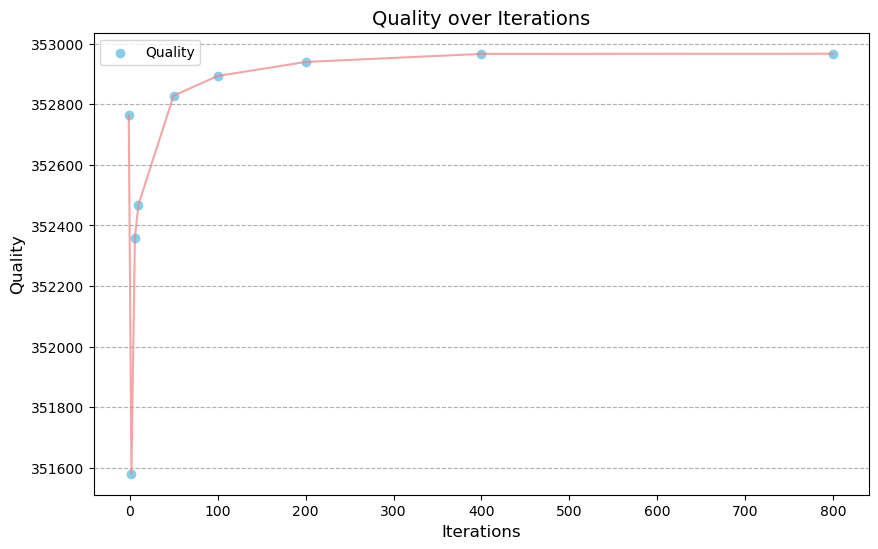

In [16]:
import matplotlib.pyplot as plt

# Data Preparation (Assuming you already have quality_values and iterations)
iterations = list(quality_values.keys())
quality = list(quality_values.values())

# Plotting with Enhanced Visuals
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability

# Use scatter plot for discrete data points
plt.scatter(
    iterations, quality, marker="o", color="skyblue", label="Quality"
)  # Add labels for the legend

# Add a line plot to visualize the trend
plt.plot(
    iterations, quality, color="lightcoral", linestyle="-", alpha=0.7
)  # Line plot with transparency

plt.xlabel("Iterations", fontsize=12)
plt.ylabel("Quality", fontsize=12)
plt.title("Quality over Iterations", fontsize=14)

# Improved Tick Labels and Gridlines
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--")  # Add subtle gridlines for better readability

# Legend
plt.legend()

# Save Figure
output_path = (
    "../output/figures/leiden_iterations_quality_plot_alpha0.3_k10_res0.002.png"
)
plt.savefig(output_path, dpi=300)  # Save high-resolution figure

plt.show()

# Safe final partition with 200 iterations


In [17]:
params = "alpha0.3_k10_res0.002"
iterations = 200
quality_values = {}
G = params_graph_dict[params.split("_res")[0]]
resolution = pd.to_numeric(params.split("res")[1])
pc = PartitionCreator(G, df)
pc.create_partition_from_cmpvertexpartition(
    n_iterations=iterations,
    resolution_parameter=resolution,
    verbose=True,
    cluster_column_name=f"cluster_{params}",
    centrality_column_name=f"centrality_{params}",
)
# save graphml
pc.G.write_graphml(f"../data/07-clustered-graphs/{params}.graphml")
path = f"../data/06-clustered-df/{params}.pkl"
pc.df.to_pickle(path)
#############################
#############################
ce = CommunityExplorer(
    df=pc.df,
    cluster_column=f"cluster_{params}",
    sort_column=f"centrality_{params}",
    nr_tiles=20,
)
ce.create_full_explorer()
df_summary, cluster_titles_sheets_dict = ce.full_return()

# save to excel
filepath = f"../output/cluster-qualifications/cluster-explorer/FinalSelect/DELFinalRun_i{iterations}_SingleSolExplorer_{params}.xlsx"
NetworkAnalyzerUtils().clusters_excel_saver_with_hyperlinks(
    filepath, df_summary, cluster_titles_sheets_dict
)
filepath = f"../output/cluster-qualifications/cluster-explorer/FinalSelect/SingleSolExplorer_{params}.xlsx"
NetworkAnalyzerUtils().clusters_excel_saver_with_hyperlinks(
    filepath, df_summary, cluster_titles_sheets_dict
)
print(f"Iterations: {iterations}")
print(f"Params: {params}")
print("#" * 50)

Number of clusters: 150
Quality: 352939.8211424463
Iterations: 200
Params: alpha0.3_k10_res0.002
##################################################


In [25]:
cluster_titles_sheets_dict.keys()

dict_keys([55, 66, 46, 11, 25, 52, 115, 49, 42, 2, 86, 60, 87, 0, 69, 76, 1, 39, 8, 54, 98, 43, 3, 44, 28, 127, 13, 47, 29, 32, 12, 79, 148, 40, 26, 110, 113, 5, 74, 63, 84, 59, 112, 83, 107, 16, 99, 56, 51, 57, 4, 96, 22, 88, 75, 23, 91, 77, 41, 134, 61, 6, 116, 71, 15, 31, 131, 64, 68, 17, 19, 65, 24, 67, 146, 50, 97, 92, 124, 135, 82, 20, 101, 89, 7, 85, 36, 70, 35, 114, 94, 27, 122, 48, 62, 58, 53, 100, 9, 143, 111, 34, 14, 132, 104, 80, 78, 125, 128, 118, 133, 108, 138, 109, 30, 73, 93, 37, 45, 102, 121, 105, 21, 126, 142, 72, 10, 38, 18, 81, 90, 123, 130, 117, 149, 103, 33, 129, 95, 139, 136, 147, 144, 137, 106, 145, 119, 141, 140, 120])